# Room Occupancy Estimator

## Import Libraries 

In [390]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from numpy.polynomial.polynomial import Polynomial
from scipy import stats
import matplotlib.dates as mdates


# Import CSV

In [391]:
df_raw = pd.read_csv('../data/Occupancy_Estimation.csv')

# Explore the Dataframe to understand 

In [392]:
df_raw.head()

Date      Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
0  2017/12/22  10:49:41    24.94    24.75    24.56    25.38       121   
1  2017/12/22  10:50:12    24.94    24.75    24.56    25.44       121   
2  2017/12/22  10:50:42    25.00    24.75    24.50    25.44       121   
3  2017/12/22  10:51:13    25.00    24.75    24.56    25.44       121   
4  2017/12/22  10:51:44    25.00    24.75    24.56    25.44       121   

   S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  \
0        34        53        40      0.08      0.19      0.06      0.06   
1        33        53        40      0.93      0.05      0.06      0.06   
2        34        53        40      0.43      0.11      0.08      0.06   
3        34        53        40      0.41      0.10      0.10      0.09   
4        34        54        40      0.18      0.06      0.06      0.06   

   S5_CO2  S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count  
0     390      0.769231       0       0                     1  
1     390      0.646154       0       0                     1  
2     390      0.519231       0       0                     1  
3     390      0.388462       0       0                     1  
4     390      0.253846       0       0                     1

## What is the shape of the data? 

In [393]:
df_raw.shape

(10129, 19)

In [394]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

# Pre-processing

# Concatenate Date and Time and set to datetime

In [395]:
# Combine date and time columns
if 'Date' in df_raw.columns and 'Time' in df_raw.columns:
    df_raw['datetime_str'] = df_raw['Date'] + ' ' + df_raw['Time']

    # Convert the combined column to datetime
    df_raw['datetime'] = pd.to_datetime(df_raw['datetime_str'])

    # Drop the original date and time columns
    df_raw.drop(columns=['Date', 'Time', 'datetime_str'], inplace=True)

# Get a list of all the columns
cols = list(df_raw.columns)

# Remove 'datetime' from the list if it exists
if 'datetime' in cols:
    cols.remove('datetime')

# Reorder the DataFrame to have 'datetime' as the first column
df_cleaned = df_raw[['datetime'] + cols]

In [396]:
df_cleaned.head()

datetime  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  \
0 2017-12-22 10:49:41    24.94    24.75    24.56    25.38       121        34   
1 2017-12-22 10:50:12    24.94    24.75    24.56    25.44       121        33   
2 2017-12-22 10:50:42    25.00    24.75    24.50    25.44       121        34   
3 2017-12-22 10:51:13    25.00    24.75    24.56    25.44       121        34   
4 2017-12-22 10:51:44    25.00    24.75    24.56    25.44       121        34   

   S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  \
0        53        40      0.08      0.19      0.06      0.06     390   
1        53        40      0.93      0.05      0.06      0.06     390   
2        53        40      0.43      0.11      0.08      0.06     390   
3        53        40      0.41      0.10      0.10      0.09     390   
4        54        40      0.18      0.06      0.06      0.06     390   

   S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count  
0      0.769231       0       0                     1  
1      0.646154       0       0                     1  
2      0.519231       0       0                     1  
3      0.388462       0       0                     1  
4      0.253846       0       0                     1

## Check missing values

In [397]:
df_cleaned.isnull().sum()

datetime                0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [398]:
df_cleaned.describe()

datetime       S1_Temp       S2_Temp  \
count                          10129  10129.000000  10129.000000   
mean   2017-12-27 20:27:23.034554112     25.454012     25.546059   
min              2017-12-22 10:49:41     24.940000     24.750000   
25%              2017-12-23 09:14:33     25.190000     25.190000   
50%              2017-12-24 07:06:45     25.380000     25.380000   
75%              2017-12-26 04:58:18     25.630000     25.630000   
max              2018-01-11 09:00:09     26.380000     29.000000   
std                              NaN      0.351351      0.586325   

            S3_Temp       S4_Temp      S1_Light     S2_Light      S3_Light  \
count  10129.000000  10129.000000  10129.000000  10129.00000  10129.000000   
mean      25.056621     25.754125     25.445059     26.01629     34.248494   
min       24.440000     24.940000      0.000000      0.00000      0.000000   
25%       24.690000     25.440000      0.000000      0.00000      0.000000   
50%       24.940000     25.750000      0.000000      0.00000      0.000000   
75%       25.380000     26.000000     12.000000     14.00000     50.000000   
max       26.190000     26.560000    165.000000    258.00000    280.000000   
std        0.427283      0.356434     51.011264     67.30417     58.400744   

           S4_Light      S1_Sound      S2_Sound      S3_Sound      S4_Sound  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      13.220259      0.168178      0.120066      0.158119      0.103840   
min        0.000000      0.060000      0.040000      0.040000      0.050000   
25%        0.000000      0.070000      0.050000      0.060000      0.060000   
50%        0.000000      0.080000      0.050000      0.060000      0.080000   
75%       22.000000      0.080000      0.060000      0.070000      0.100000   
max       74.000000      3.880000      3.440000      3.670000      3.400000   
std       19.602219      0.316709      0.266503      0.413637      0.120683   

             S5_CO2  S5_CO2_Slope        S6_PIR        S7_PIR  \
count  10129.000000  10129.000000  10129.000000  10129.000000   
mean     460.860401     -0.004830      0.090137      0.079574   
min      345.000000     -6.296154      0.000000      0.000000   
25%      355.000000     -0.046154      0.000000      0.000000   
50%      360.000000      0.000000      0.000000      0.000000   
75%      465.000000      0.000000      0.000000      0.000000   
max     1270.000000      8.980769      1.000000      1.000000   
std      199.964940      1.164990      0.286392      0.270645   

       Room_Occupancy_Count  
count          10129.000000  
mean               0.398559  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                3.000000  
std                0.893633

In [399]:
df_cleaned.columns

Index(['datetime', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

## Check for outliers

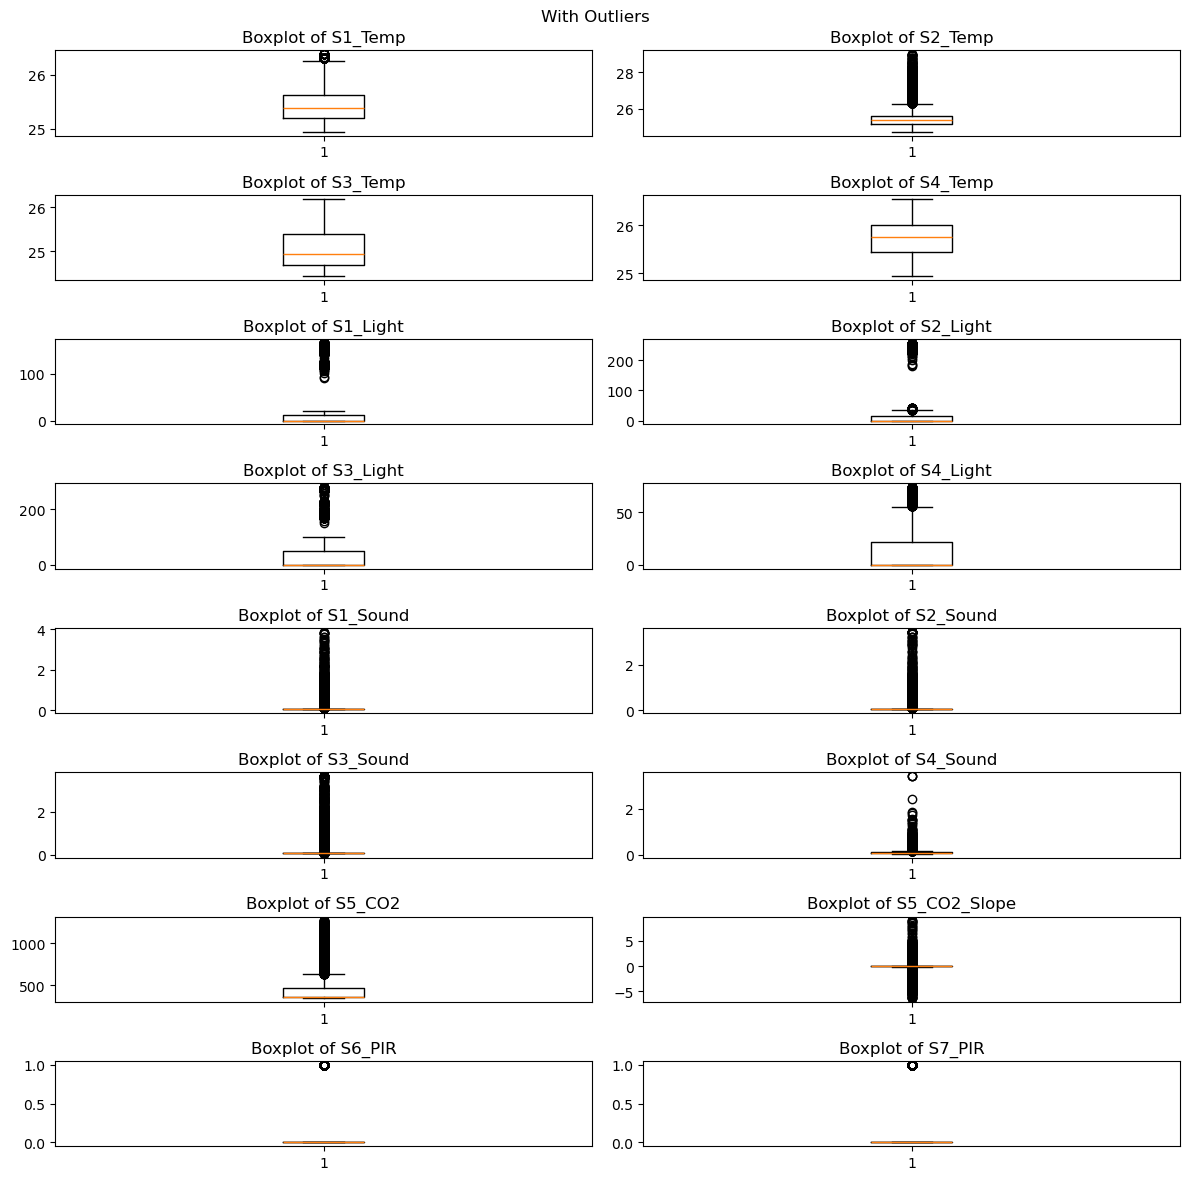

In [400]:
#Check sensor outliers 
sensors = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']

    # Plot boxplot for visualization
fig, axs = plt.subplots(len(sensors) // 2, 2, figsize=(12, 12))

for i, sensor in enumerate(sensors):
    row = i // 2
    col = i % 2
    axs[row, col].boxplot(df_cleaned[sensor].dropna())
    axs[row, col].set_title(f"Boxplot of {sensor}")

plt.suptitle("With Outliers")
plt.tight_layout()
plt.show()

### There are outliers observed in the data

## Remove outliers

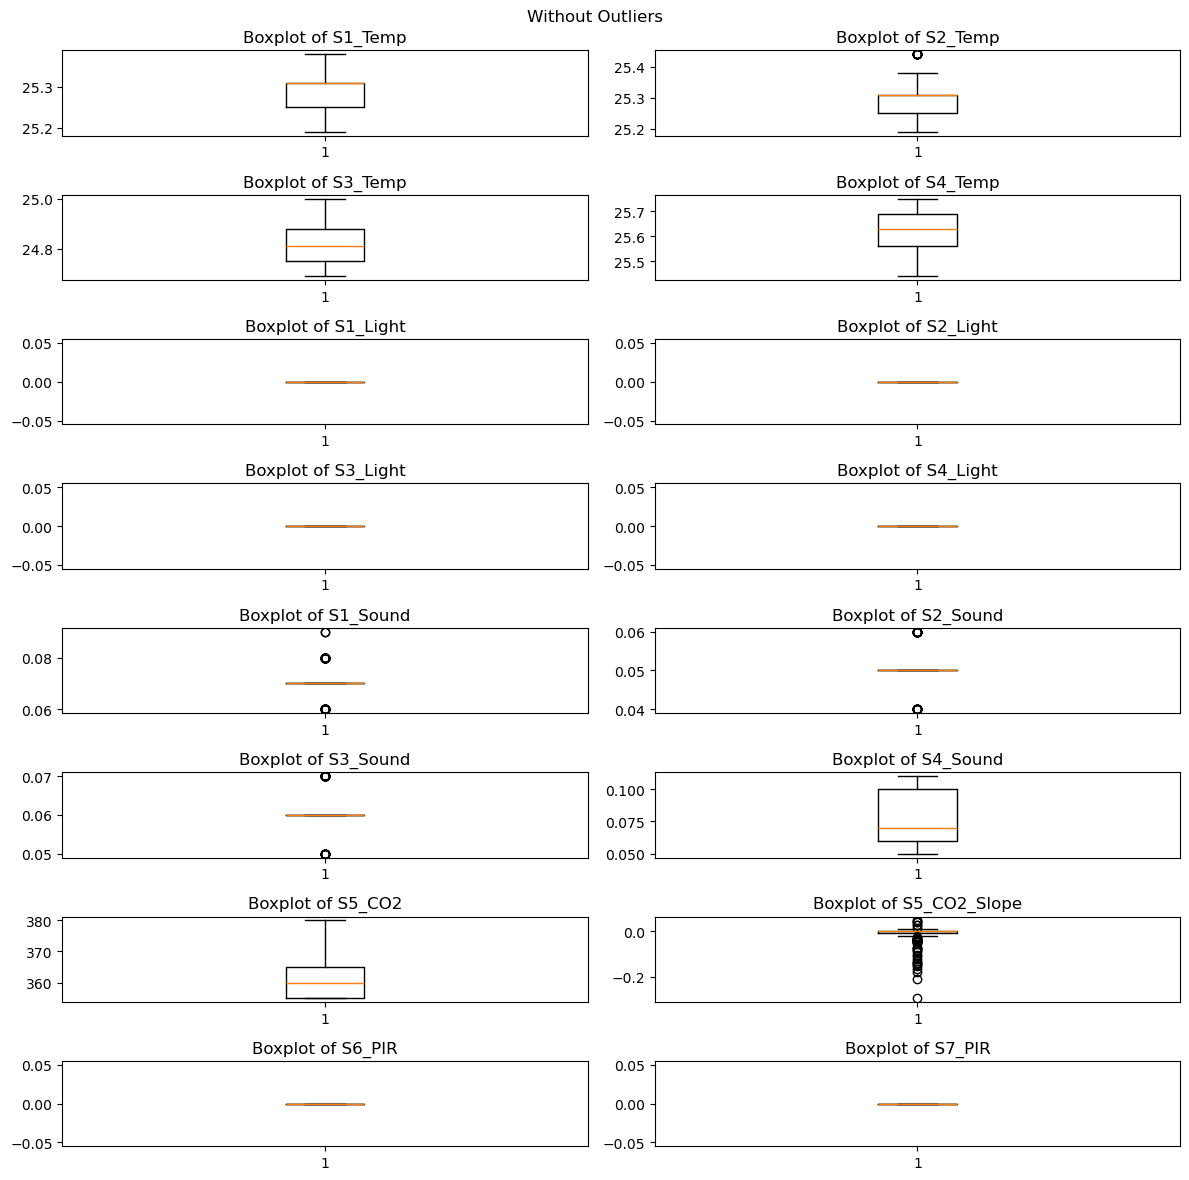

In [401]:
from scipy.spatial import distance

sensors = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']

# Select only the sensor columns
df_sensors = df_raw[sensors]

# Calculate the mean and covariance of the sensor data
mean = df_sensors.mean()
cov = df_sensors.cov()

# Calculate the Mahalanobis distance of each data point
distances = df_sensors.apply(lambda row: distance.mahalanobis(row, mean, np.linalg.inv(cov)), axis=1)

# Define a threshold for the Mahalanobis distance
threshold = np.percentile(distances, 2)  # Adjust this value as needed

# Create a mask for the outliers
mask = distances < threshold

# Remove the outliers from the sensor columns
df_cleaned = df_raw.copy()
df_cleaned.loc[~mask, sensors] = np.nan

# Plot boxplot for visualization
fig, axs = plt.subplots(len(sensors) // 2, 2, figsize=(12, 12))

for i, sensor in enumerate(sensors):
    row = i // 2
    col = i % 2
    axs[row, col].boxplot(df_cleaned[sensor].dropna())
    axs[row, col].set_title(f"Boxplot of {sensor}")

plt.suptitle("Without Outliers")
plt.tight_layout()
plt.show()

In [402]:
df_cleaned.head()

S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  \
0      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
1      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
3      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
4      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   

   S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  S6_PIR  \
0       NaN       NaN       NaN       NaN     NaN           NaN     NaN   
1       NaN       NaN       NaN       NaN     NaN           NaN     NaN   
2       NaN       NaN       NaN       NaN     NaN           NaN     NaN   
3       NaN       NaN       NaN       NaN     NaN           NaN     NaN   
4       NaN       NaN       NaN       NaN     NaN           NaN     NaN   

   S7_PIR  Room_Occupancy_Count            datetime  
0     NaN                     1 2017-12-22 10:49:41  
1     NaN                     1 2017-12-22 10:50:12  
2     NaN                     1 2017-12-22 10:50:42  
3     NaN                     1 2017-12-22 10:51:13  
4     NaN                     1 2017-12-22 10:51:44

In [403]:
df_cleaned.shape

(10129, 18)

In [404]:
df_cleaned.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'datetime'],
      dtype='object')

In [405]:
df_cleaned.dtypes

S1_Temp                        float64
S2_Temp                        float64
S3_Temp                        float64
S4_Temp                        float64
S1_Light                       float64
S2_Light                       float64
S3_Light                       float64
S4_Light                       float64
S1_Sound                       float64
S2_Sound                       float64
S3_Sound                       float64
S4_Sound                       float64
S5_CO2                         float64
S5_CO2_Slope                   float64
S6_PIR                         float64
S7_PIR                         float64
Room_Occupancy_Count             int64
datetime                datetime64[ns]
dtype: object

## Normalize sensor data by computing the mean

In [406]:
# Calculate the mean of the temperature columns
temp_mean = df_cleaned.loc[:, 'S1_Temp':'S4_Temp'].mean(axis=1)

# Calculate the mean of the light columns
light_mean = df_cleaned.loc[:, 'S1_Light':'S4_Light'].mean(axis=1)

# Calculate the mean of the sound columns
sound_mean = df_cleaned.loc[:, 'S1_Sound':'S4_Sound'].mean(axis=1)

# Calculate the mean of the CO2 columns
co2_mean = df_cleaned['S5_CO2']

# Calculate the mean of the CO2_Slope columns
co2_slope_mean = df_cleaned['S5_CO2_Slope']

# Calculate the mean of the PIR columns
pir_mean = df_cleaned.loc[:, 'S6_PIR':'S7_PIR'].mean(axis=1)

# Append the new columns at the end of the DataFrame using .loc
df_cleaned.loc[:, 'Mean_Temperature'] = temp_mean
df_cleaned.loc[:, 'Mean_light'] = light_mean
df_cleaned.loc[:, 'Mean_sound'] = sound_mean
df_cleaned.loc[:, 'Mean_CO2'] = co2_mean
df_cleaned.loc[:, 'Mean_CO2_Slope'] = co2_slope_mean
df_cleaned.loc[:, 'Mean_PIR'] = pir_mean

In [407]:
df_cleaned.head(3)

S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  \
0      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
1      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   
2      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN   

   S1_Sound  S2_Sound  ...  S6_PIR  S7_PIR  Room_Occupancy_Count  \
0       NaN       NaN  ...     NaN     NaN                     1   
1       NaN       NaN  ...     NaN     NaN                     1   
2       NaN       NaN  ...     NaN     NaN                     1   

             datetime  Mean_Temperature  Mean_light  Mean_sound Mean_CO2  \
0 2017-12-22 10:49:41               NaN         NaN         NaN      NaN   
1 2017-12-22 10:50:12               NaN         NaN         NaN      NaN   
2 2017-12-22 10:50:42               NaN         NaN         NaN      NaN   

   Mean_CO2_Slope  Mean_PIR  
0             NaN       NaN  
1             NaN       NaN  
2             NaN       NaN  

[3 rows x 24 columns]

# Visualization

## Visualize the normalized sensor readings

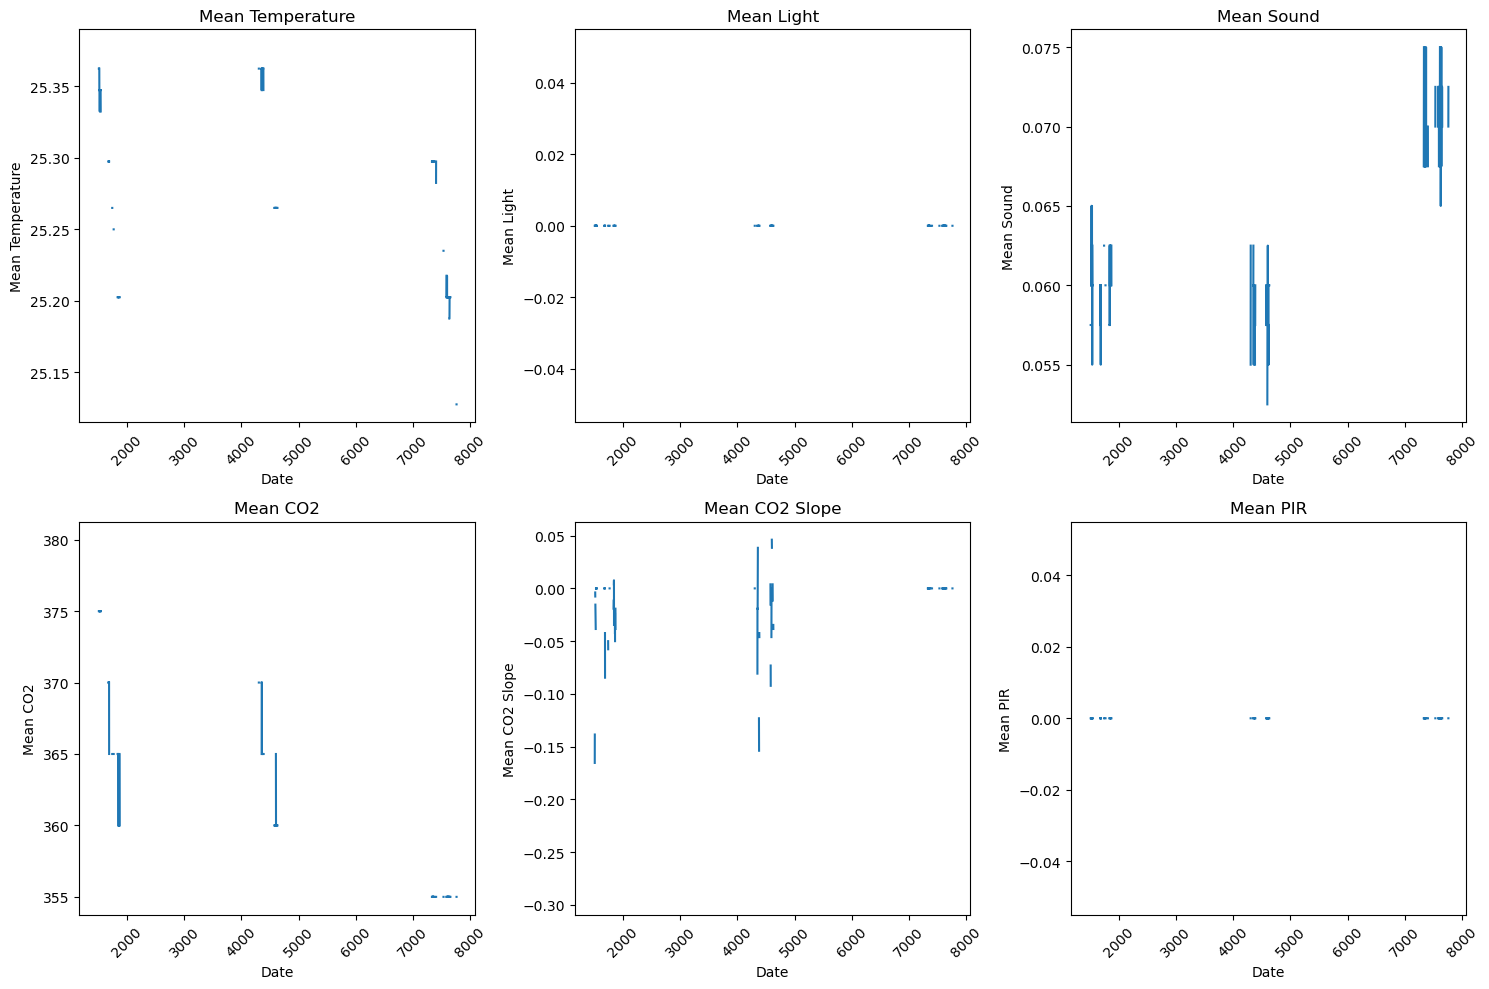

In [408]:
# visualize the mean sensor readings
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Define the sensor readings and their titles
sensor_readings = ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']
titles = ['Mean Temperature', 'Mean Light', 'Mean Sound', 'Mean CO2', 'Mean CO2 Slope', 'Mean PIR']

# Iterate over the sensor readings and plot them
for i, (sensor_reading, title) in enumerate(zip(sensor_readings, titles)):
    row = i // 3
    col = i % 3
    axs[row, col].plot(df_cleaned.index, df_cleaned[sensor_reading])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel(title)
    plt.setp(axs[row, col].xaxis.get_majorticklabels(), rotation=45)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Rolling mean

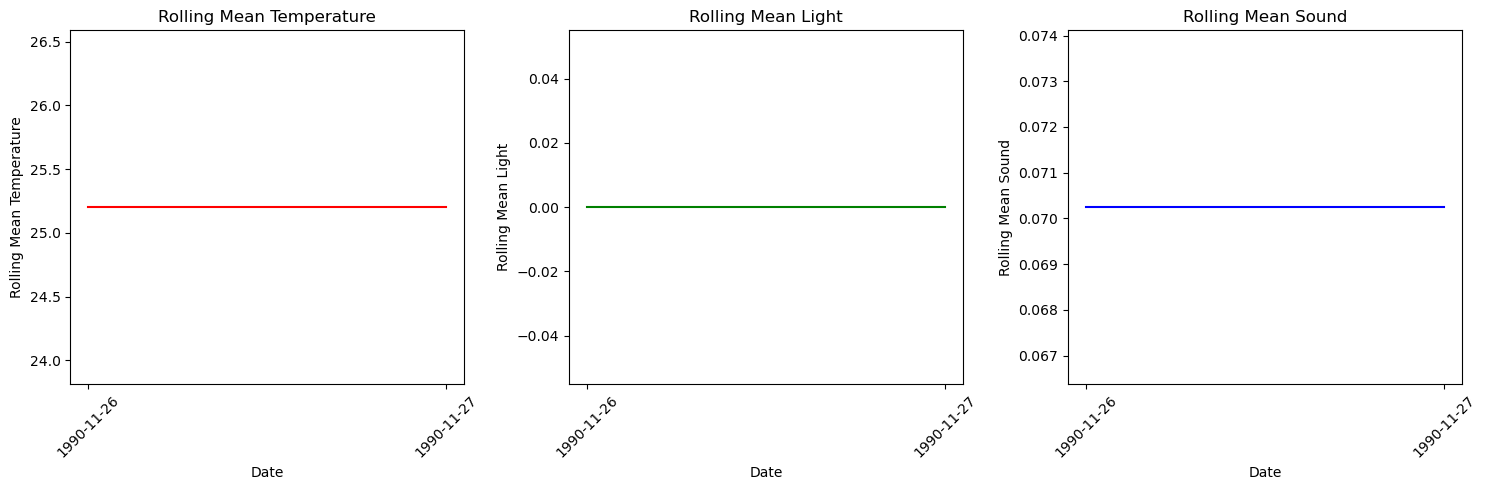

In [409]:


# Define the rolling window size
window_size = 10

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define the sensor readings, their colors, and their titles
sensor_readings = ['Mean_Temperature', 'Mean_light', 'Mean_sound']
colors = ['red', 'green', 'blue']
titles = ['Rolling Mean Temperature', 'Rolling Mean Light', 'Rolling Mean Sound']

# Iterate over the sensor readings and plot their rolling means
for i, (sensor_reading, color, title) in enumerate(zip(sensor_readings, colors, titles)):
    axs[i].plot(df_cleaned.index, df_cleaned[sensor_reading].rolling(window_size).mean(), color=color)
    axs[i].set_title(title)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(title)
    
    # Set x-axis to display dates in a specific format
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Weekend vs weekday analysis

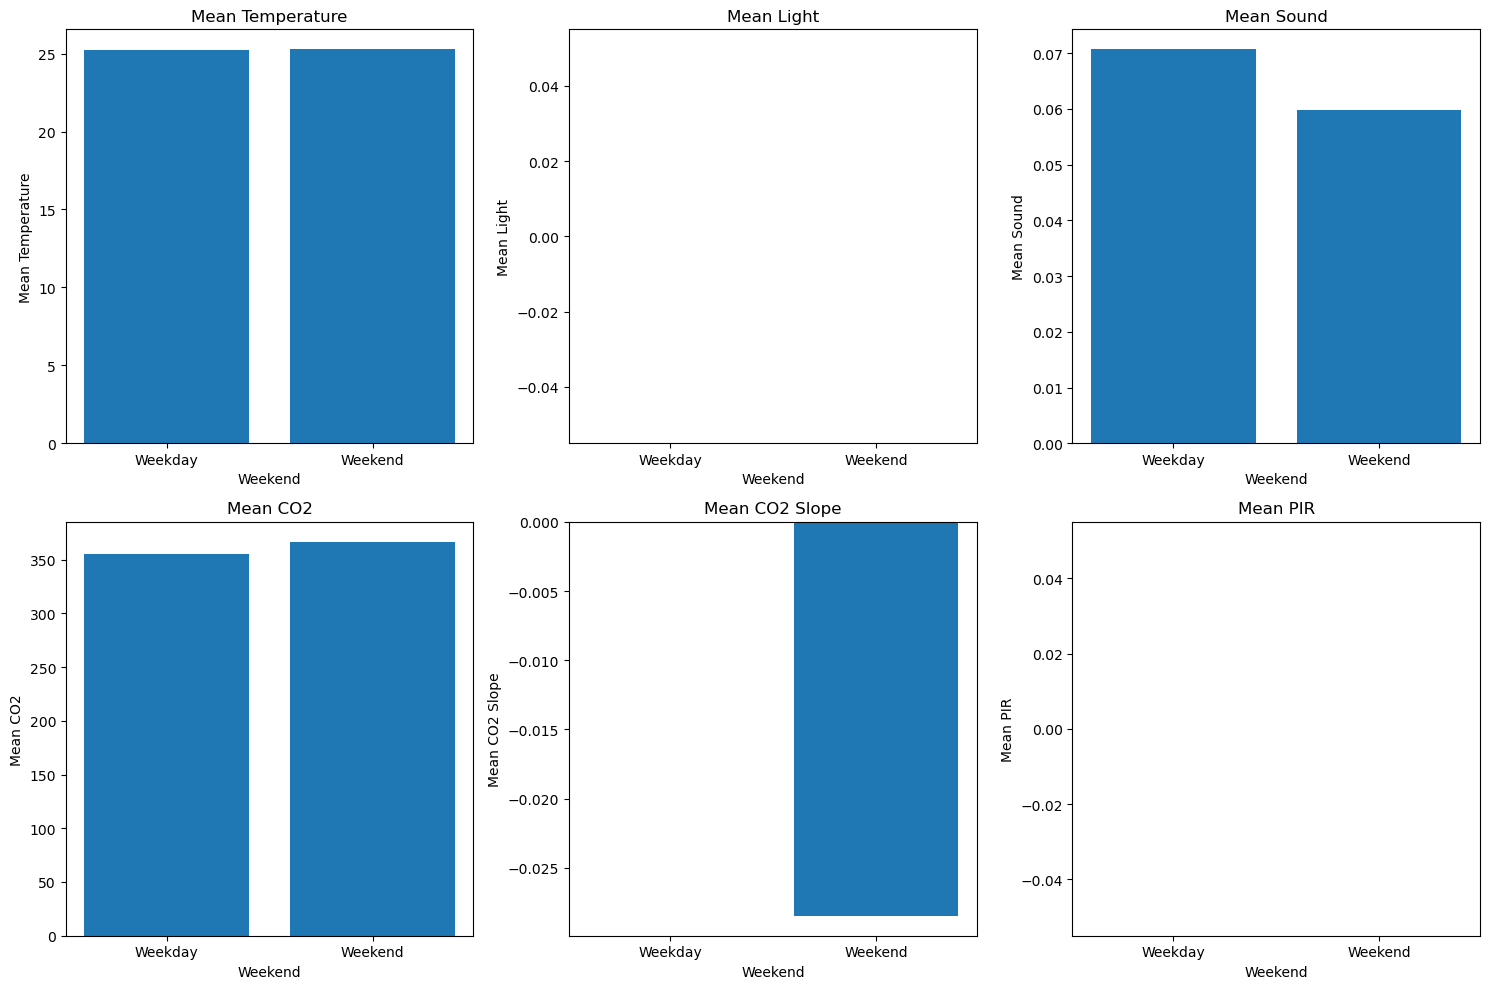

In [375]:
# Create a new column 'is_weekend' that is True if the day of the week is a weekend and False otherwise
df_cleaned.loc[:, 'is_weekend'] = np.where(df_cleaned['datetime'].dt.dayofweek < 5, 'Weekday', 'Weekend')

# Group by the 'is_weekend' column and calculate the mean of the other columns
df_grouped = df_cleaned.groupby('is_weekend').mean()

df_grouped

# Plot the grouped data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Define the sensor readings and their titles

sensor_readings = ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']
titles = ['Mean Temperature', 'Mean Light', 'Mean Sound', 'Mean CO2', 'Mean CO2 Slope', 'Mean PIR']

# Iterate over the sensor readings and plot them
for i, (sensor_reading, title) in enumerate(zip(sensor_readings, titles)):
    row = i // 3
    col = i % 3
    axs[row, col].bar(df_grouped.index, df_grouped[sensor_reading])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Weekend')
    axs[row, col].set_ylabel(title)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()




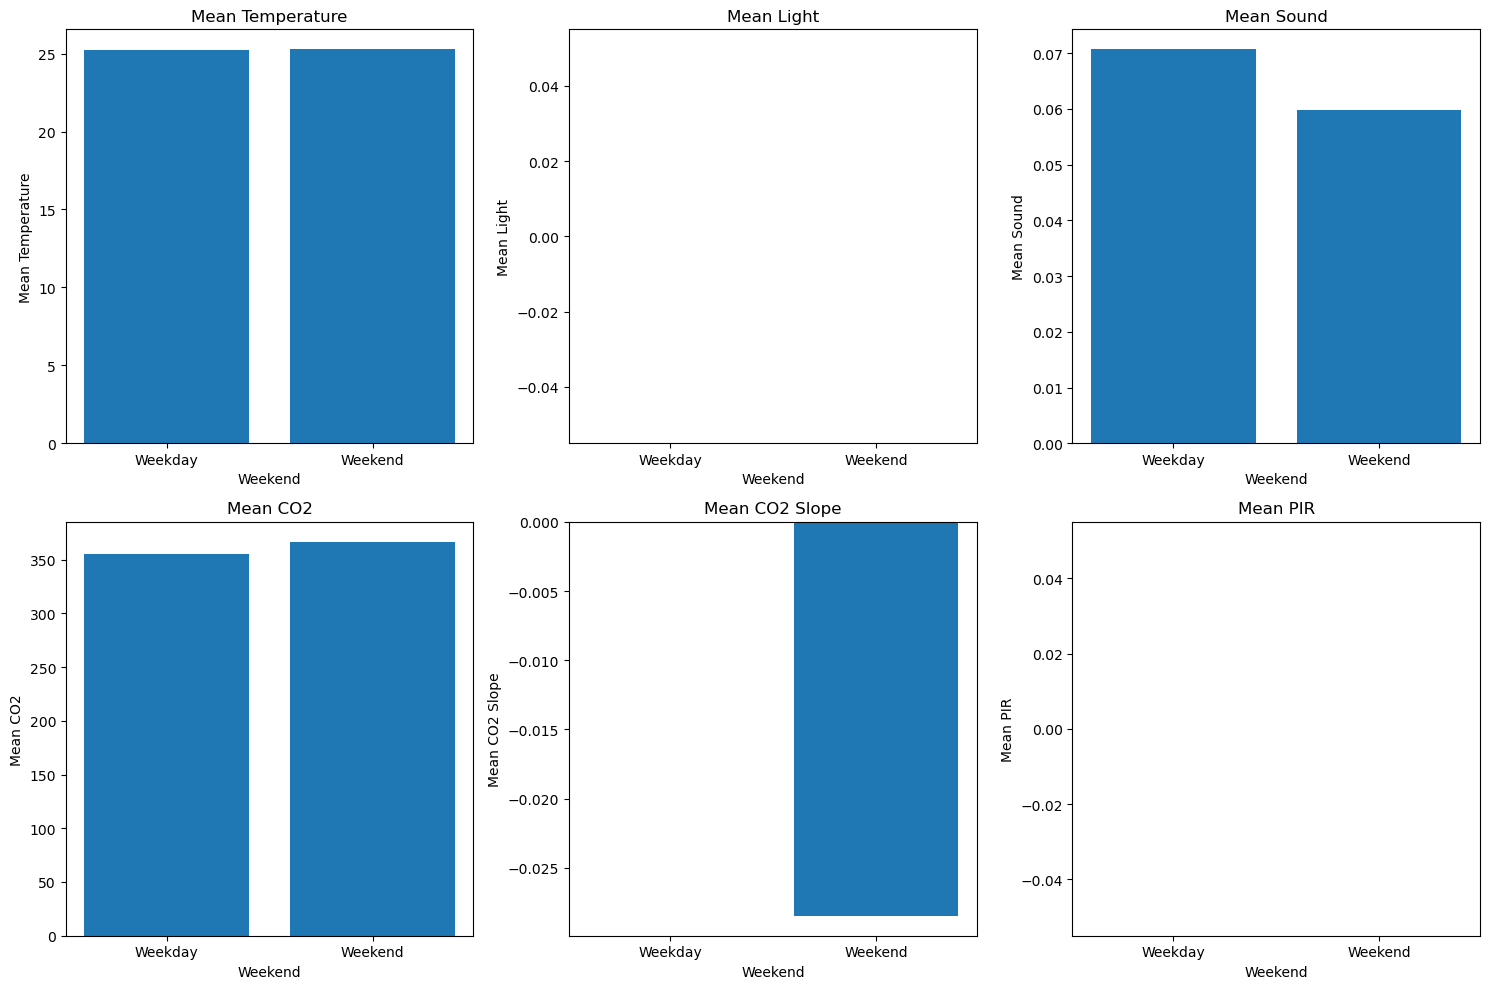

In [386]:
# Plot the grouped data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Define the sensor readings and their titles
sensor_reading= ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']
titles = ['Mean Temperature', 'Mean Light', 'Mean Sound', 'Mean CO2', 'Mean CO2 Slope', 'Mean PIR']

# Iterate over the sensor readings and plot them
for i, (sensor_reading, title) in enumerate(zip(sensor_readings, titles)):
    row = i // 3
    col = i % 3
    axs[row, col].bar(df_grouped.index, df_grouped[sensor_reading])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Weekend')
    axs[row, col].set_ylabel(title)

# Adjust the layout
plt.tight_layout()

# Save the plot
# output_dir = 'output'
# save_plot(fig, 'weekend_vs_weekday.png', output_dir)

# Show the plot
plt.show()

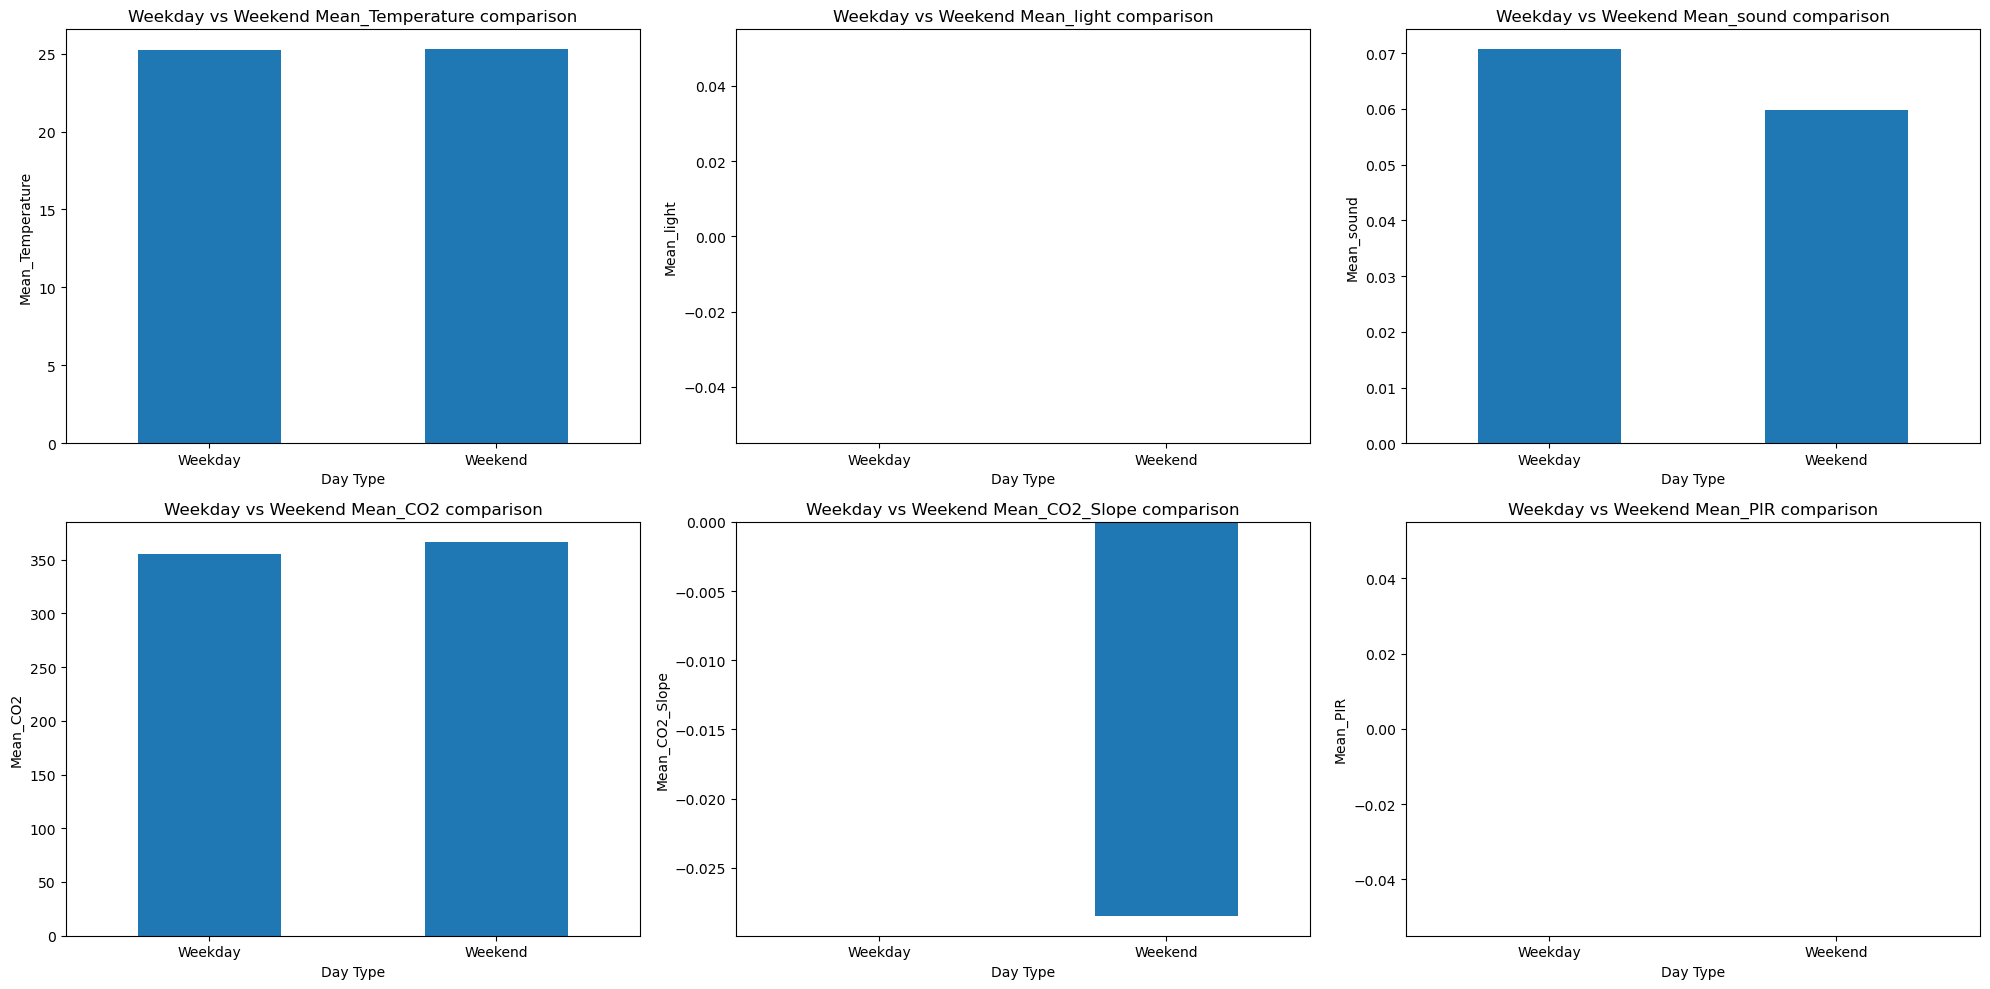

In [350]:


# List of mean columns
mean_columns = ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, column in enumerate(mean_columns):
    if column in df_grouped.columns:
        row = i // 3
        col = i % 3
        df_grouped[column].plot(kind='bar', ax=axs[row, col])
        axs[row, col].set_title('Weekday vs Weekend ' + column + ' comparison')
        axs[row, col].set_ylabel(column)
        axs[row, col].set_xlabel('Day Type')
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)  # to keep the x-axis labels vertical

plt.tight_layout()
plt.show()

## visualize and compare time series data from multiple sources to identify trends, patterns, or discrepancies in the temperature readings across different sensors.

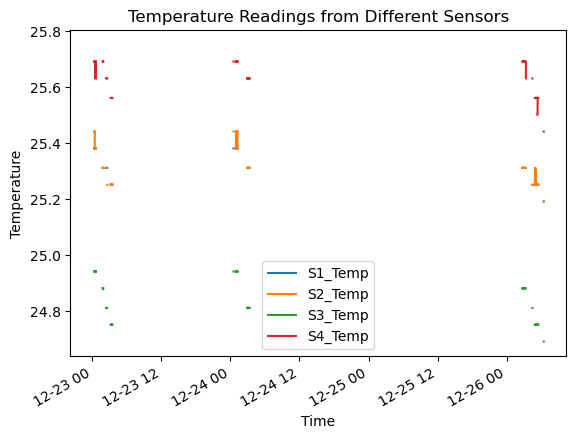

In [351]:
# Set 'datetime' column as index
df_cleaned.set_index('datetime', inplace=True)

# Compare temperature readings from different sensors
df_cleaned[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']].plot()

# Add title and labels
plt.title('Temperature Readings from Different Sensors')
plt.xlabel('Time')
plt.ylabel('Temperature')

# Format x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

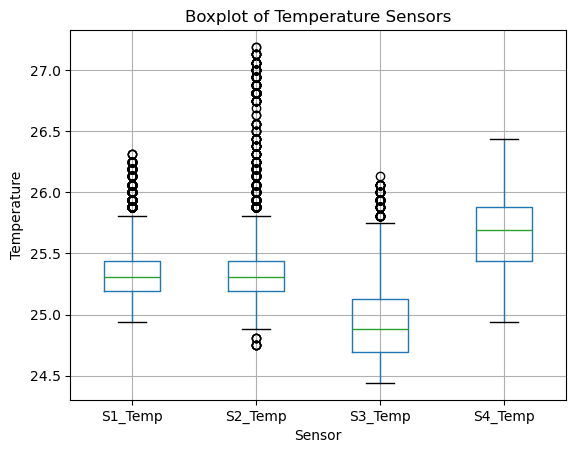

In [287]:
# Create a box plot for the temperature sensors
df_cleaned[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']].boxplot()

# Add title and labels
plt.title('Boxplot of Temperature Sensors')
plt.xlabel('Sensor')
plt.ylabel('Temperature')

plt.show()

## Autocorrelation

### 
- Analyze and visualize the autocorrelation of mean variables within the DataFrame. 
- Useful for identifying patterns in time series data, such as seasonality or the presence of a trend.

/opt/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/misc.py:457: RuntimeWarning:

invalid value encountered in scalar divide



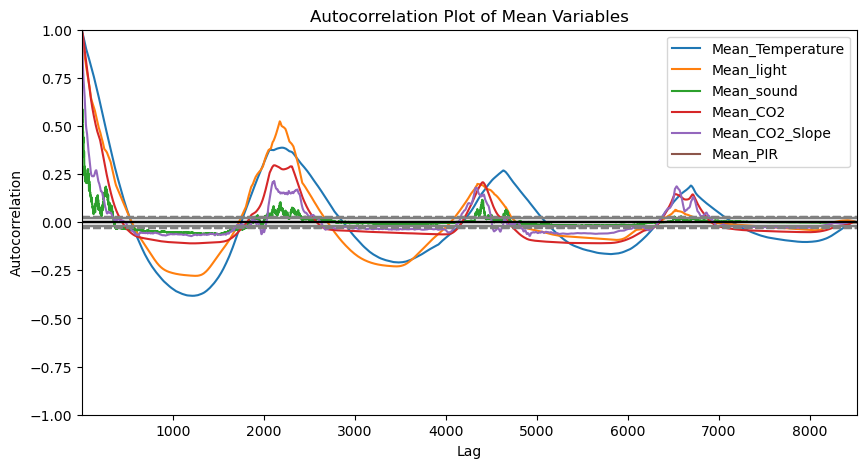

In [288]:
mean_columns = [col for col in df_cleaned.columns if 'Mean' in col]

plt.figure(figsize=(10,5))

for col in mean_columns:
    autocorrelation_plot(df_cleaned[col].dropna().tolist(), label=col)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Mean Variables')
plt.legend(loc='upper right')
plt.show()

## Pairplot of temp sensors to check for anomalies among sensor readings

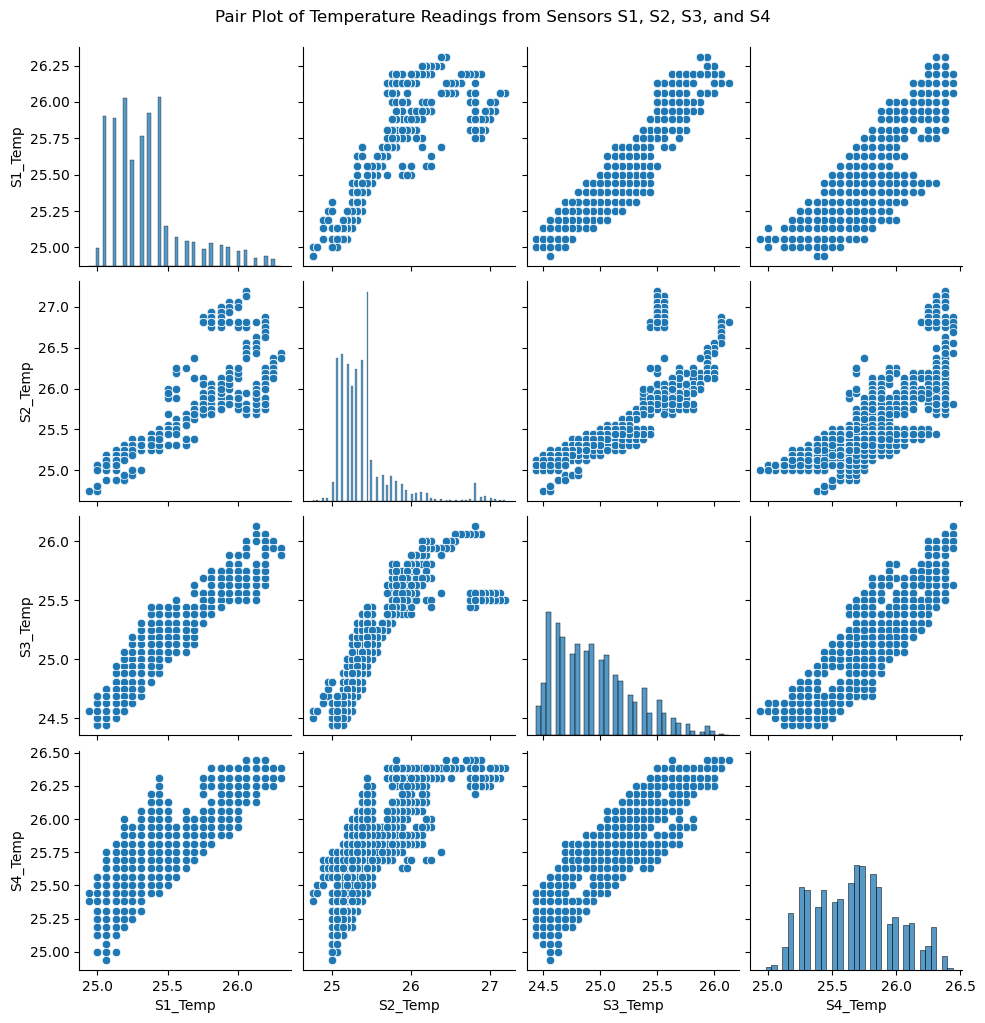

In [289]:
sns.pairplot(df_cleaned[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']])
plt.suptitle('Pair Plot of Temperature Readings from Sensors S1, S2, S3, and S4', y=1.02)  # increased y value
plt.show();

## Identify room occupancy patterns from varied environmental conditions

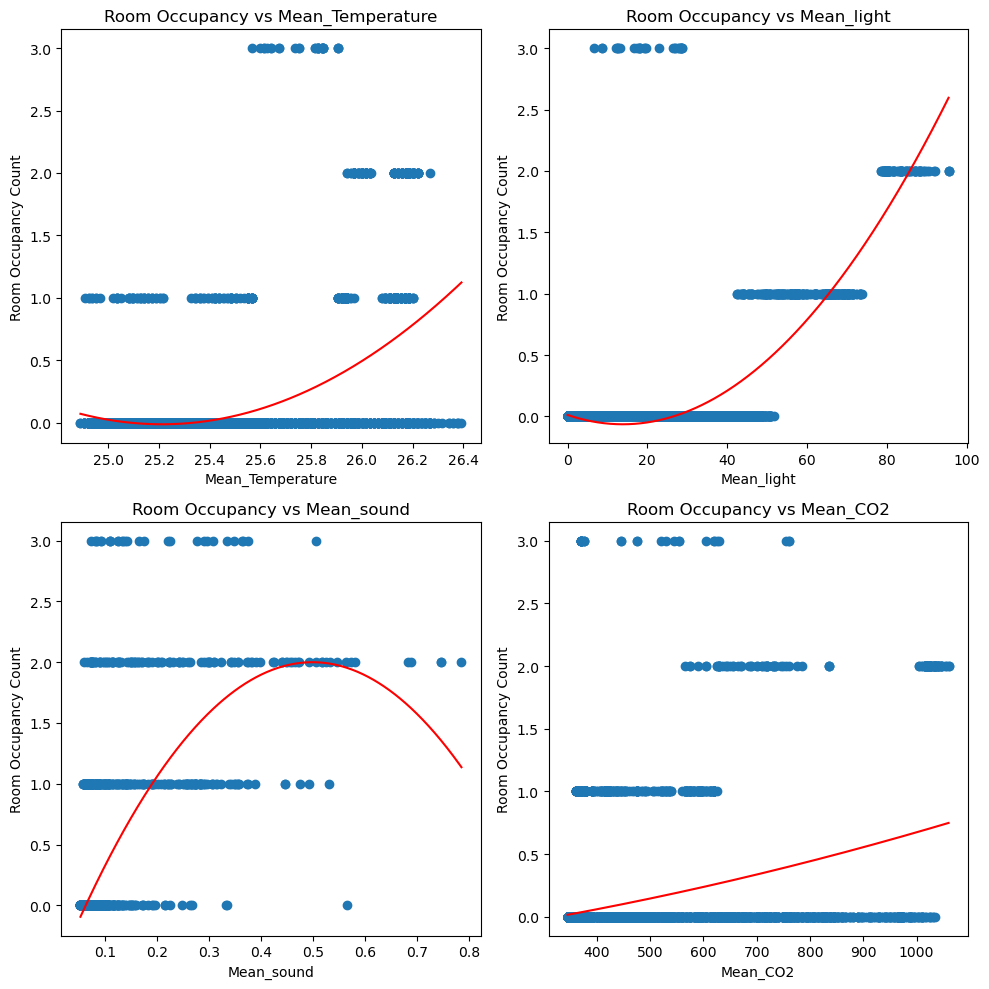

In [290]:
# Sensor readings (mean) vs Room Occupancy Count (scatter plot)
features = ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    axs[row, col].scatter(df_cleaned[feature], df_cleaned['Room_Occupancy_Count'])
        
# Fit a polynomial of degree 2 (curve line) and plot it
    x = df_cleaned[feature].dropna()
    y = df_cleaned['Room_Occupancy_Count']
    x, y = x.align(y, join='inner')
    coefs = np.polyfit(x, y, 2)
    poly = np.poly1d(coefs)
    x_new = np.linspace(x.min(), x.max(), 500)
    axs[row, col].plot(x_new, poly(x_new), 'r-')
        
    axs[row, col].set_title(f'Room Occupancy vs {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Room Occupancy Count')

plt.tight_layout()
plt.show()  

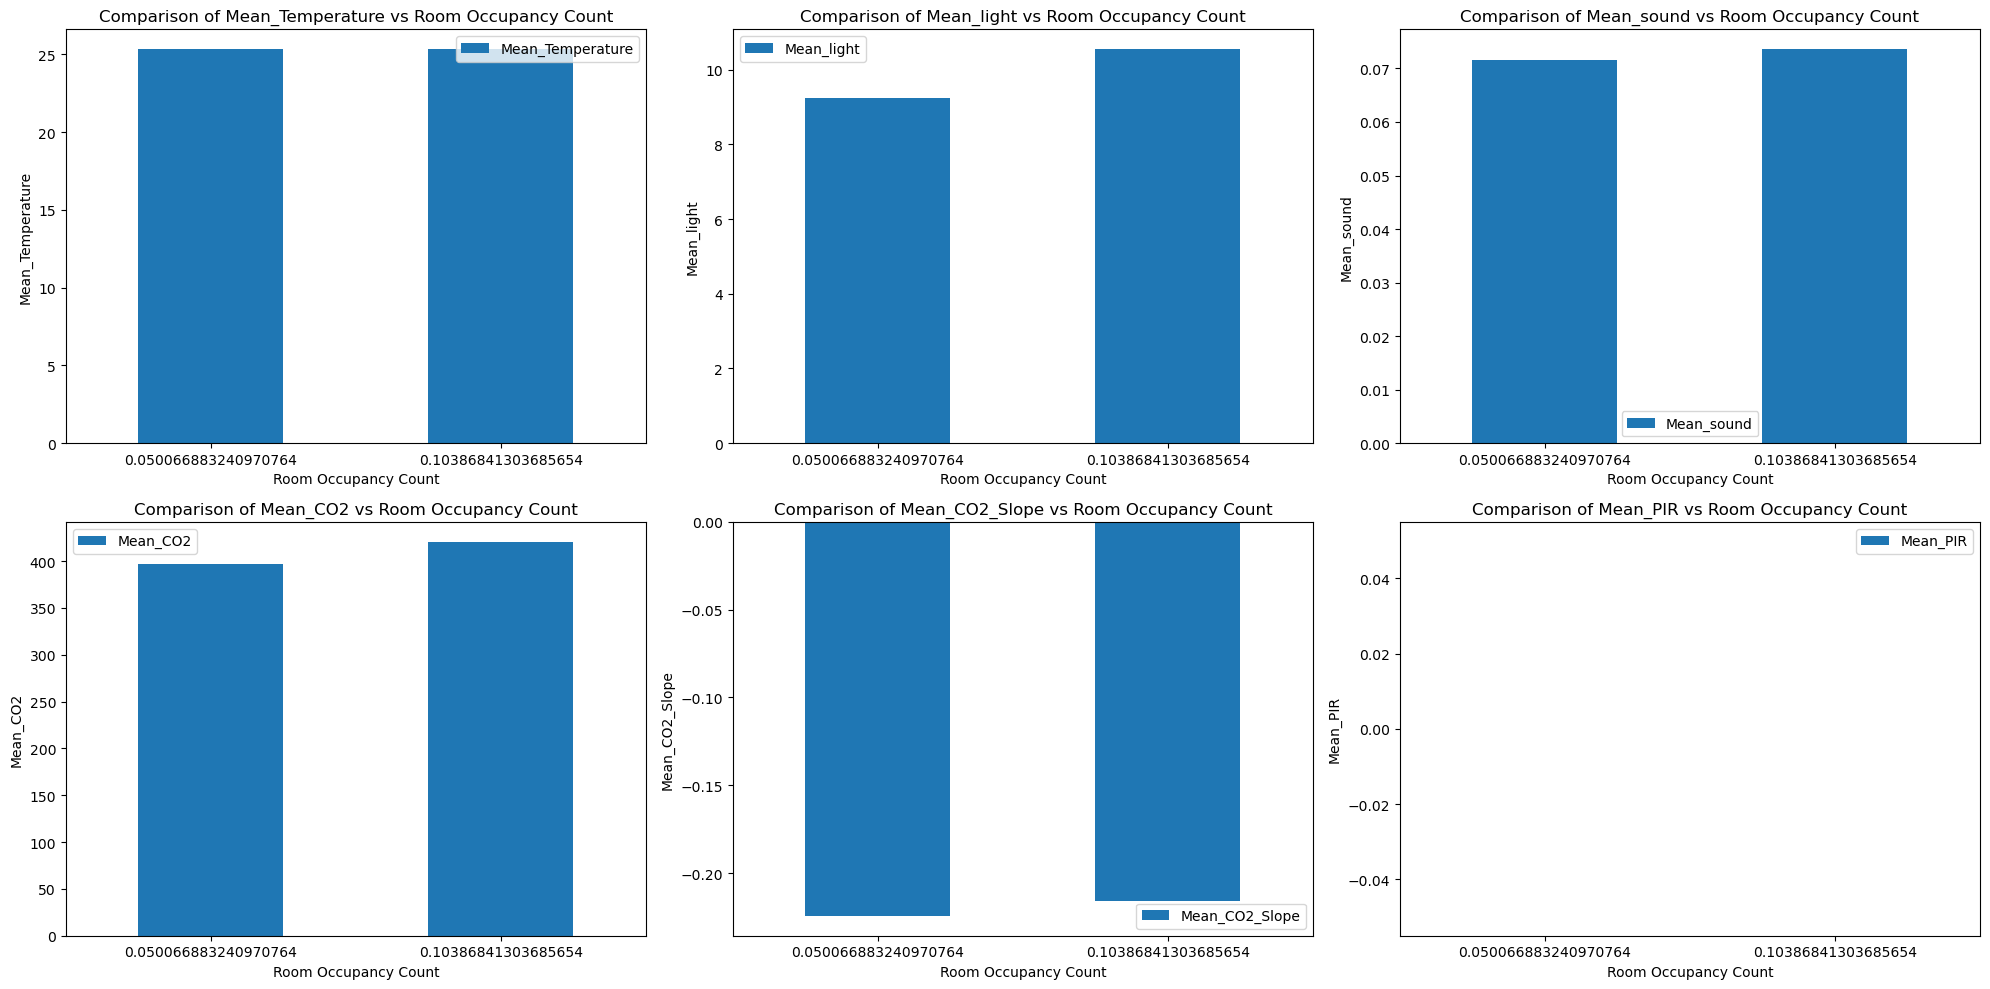

In [291]:
#Sensor readings (mean) vs Room Occupancy Count (bar plot)
# List of mean columns
mean_columns = ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, column in enumerate(mean_columns):
    if column in df_grouped.columns:
        row = i // 3
        col = i % 3
        df_grouped.plot(kind='bar', x='Room_Occupancy_Count', y=column, ax=axs[row, col])
        axs[row, col].set_title('Comparison of ' + column + ' vs Room Occupancy Count')
        axs[row, col].set_ylabel(column)
        axs[row, col].set_xlabel('Room Occupancy Count')
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)  # to keep the x-axis labels vertical

plt.tight_layout()
plt.show()

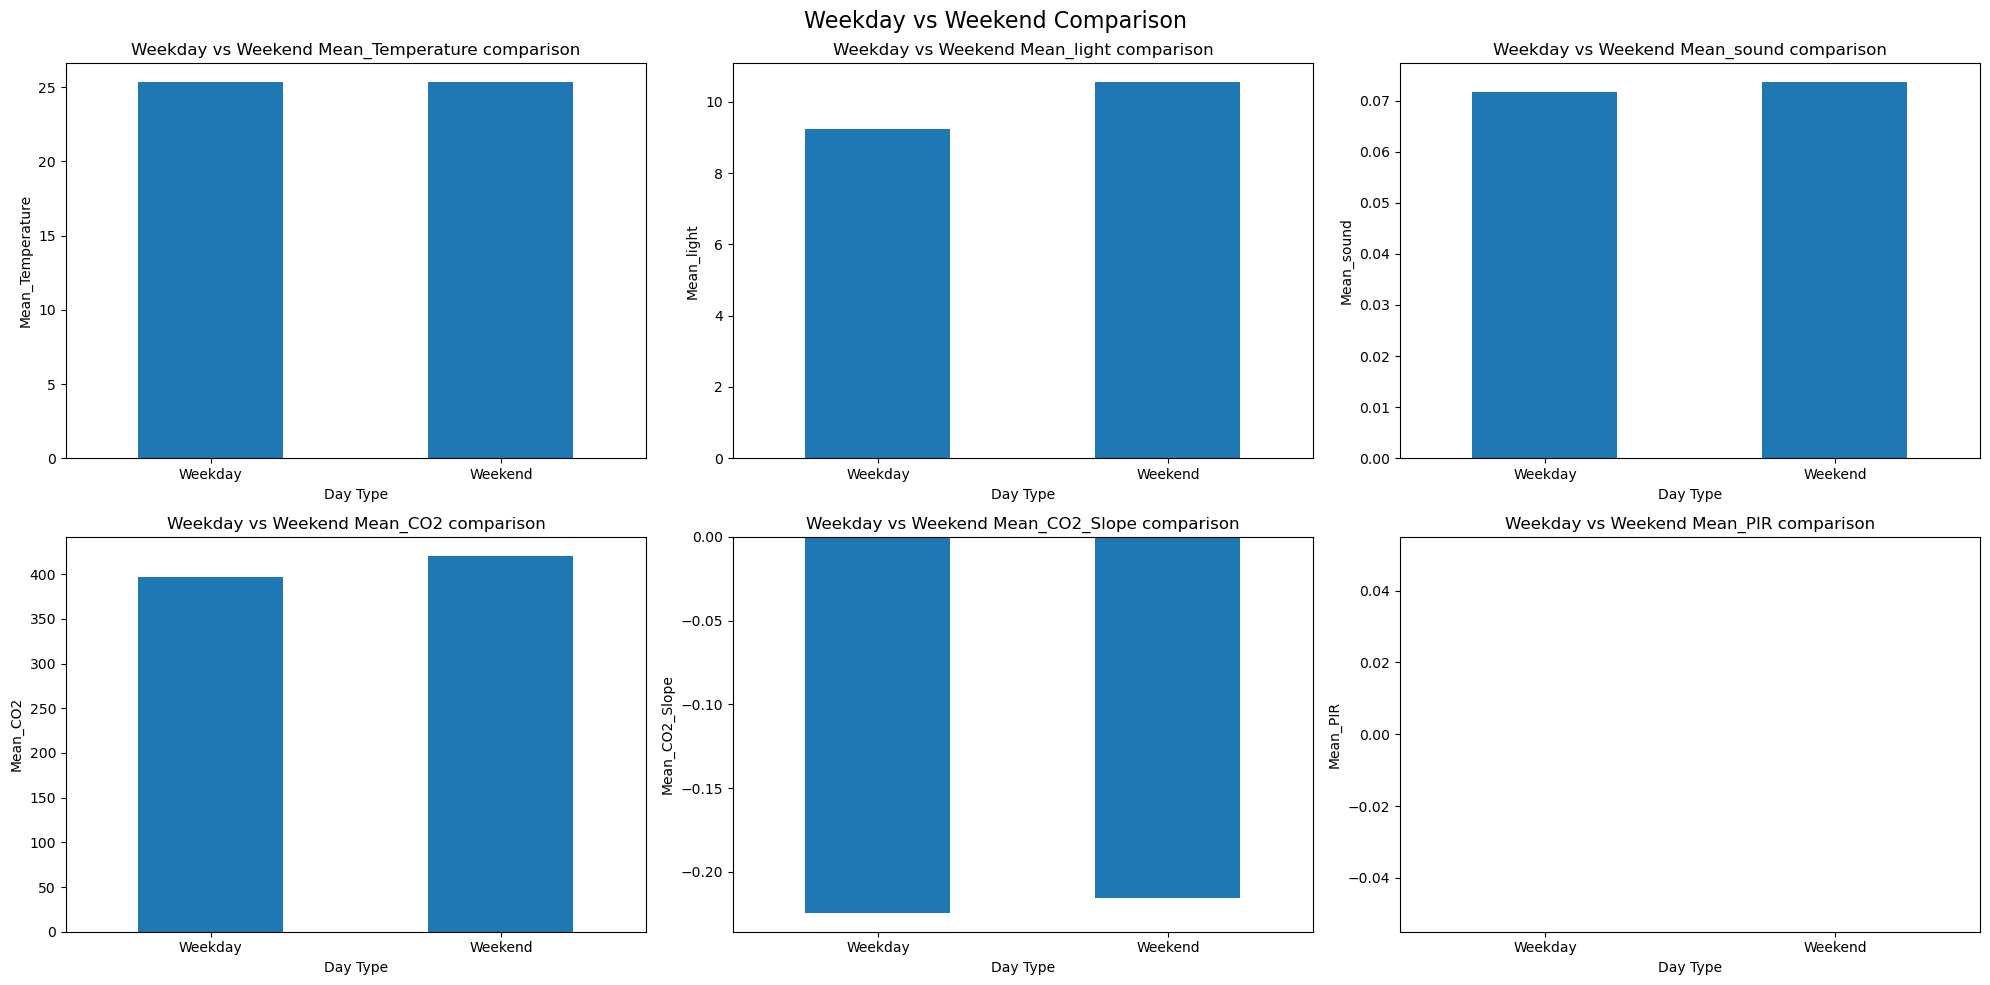

In [292]:

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Weekday vs Weekend Comparison', fontsize=16)
for i, column in enumerate(mean_columns):
    if column in df_grouped.columns:
        row = i // 3
        col = i % 3
        df_grouped[column].plot(kind='bar', ax=axs[row, col])
        axs[row, col].set_title('Weekday vs Weekend ' + column + ' comparison')
        axs[row, col].set_ylabel(column)
        axs[row, col].set_xlabel('Day Type')
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)  # to keep the x-axis labels vertical

plt.tight_layout()
plt.show()

## Correlation matrix

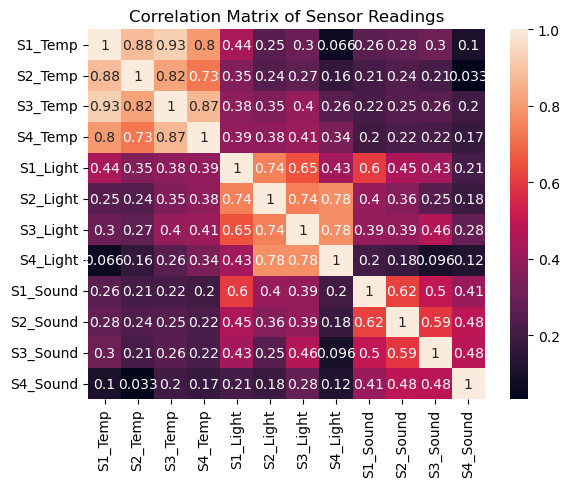

In [293]:
correlation_matrix = df_cleaned[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Sensor Readings')
plt.show()

In [294]:
# # Create a scaler object
# scaler = MinMaxScaler()

# # Fit and transform the data
# df_grouped_scaled = pd.DataFrame(scaler.fit_transform(df_grouped), columns=df_grouped.columns, index=df_grouped.index)

## Time series effect on occupancy based of varied sensor readings

In [296]:

# # Mean Sensor Readings vs Room Occupancy Count over time
# Create a figure
fig = go.Figure()

# Add traces for mean sensor readings
for column in ['Mean_Temperature', 'Mean_light', 'Mean_sound', 'Mean_CO2', 'Mean_CO2_Slope', 'Mean_PIR']:
    fig.add_trace(go.Scatter(x=df_cleaned.index, y=df_cleaned[column], name=column))

# Add trace for room occupancy count
fig.add_trace(go.Scatter(x=df_cleaned.index, y=df_cleaned['Room_Occupancy_Count'], name='Room_Occupancy_Count', yaxis='y2'))

# Update layout to include 2 y-axes and adjust legend position
fig.update_layout(
    yaxis=dict(title='Mean Sensor Readings'),
    yaxis2=dict(title='Room Occupancy Count', overlaying='y', side='right'),
    title='Mean Sensor Readings vs Room Occupancy Count',
    hovermode="x unified",
    legend=dict(x=8, y=7)  
)

fig.show()